# Import libraries and packages

In [1]:
!ls

killings_with_county_dem_and_police_info.csv  QSVM-baseline.ipynb
qiskit-textbook				      Untitled.ipynb
qiskit-tutorials


In [2]:
# import qiskit library
import qiskit
import cvxpy # dependency needed for QSVM

In [3]:
# for plotting
import matplotlib.pyplot as plt
# for matrix and linear algebra
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# preinstalled dataset
from qiskit.ml.datasets import ad_hoc_data
# basic simulator
from qiskit import BasicAer
# import Quantm Instance to run the experiment
from qiskit.aqua import QuantumInstance
# import quantum feature map
from qiskit.circuit.library import ZZFeatureMap
# import Quantum Support vector Machine model
from qiskit.aqua.algorithms import QSVM
# import several useful unitilies
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
#
print("Necessary libraries and packages are imported successfully!")

Necessary libraries and packages are imported successfully!


# Setup parameters

In [66]:
# feature dimension
feature_dim = 2
# set the seeds for the random number generator
random_seed = 42
# set shots/ number of iteration (TODO: set this higher when we're ready for the real thing)
shot = 10

In [67]:
rawdat = pd.read_csv('killings_with_county_dem_and_police_info.csv', low_memory=False)
rawdat.shape

(2546, 339)

# Setup data

In [68]:
PREDICTORS = ['age', 'POP_ESTIMATE_2016']

In [69]:
modeldat = rawdat.dropna(subset = ['calc_killed_by_police_per_10k_arrests'] + PREDICTORS,how='any')
modeldat = modeldat.sample(40)
modeldat.shape

(40, 339)

## Convert to a categorical target

In [70]:
modeldat.loc[modeldat['calc_killed_by_police_per_10k_arrests']>=5, 'target'] = 1
modeldat.loc[modeldat['calc_killed_by_police_per_10k_arrests']<5, 'target'] = 0

In [71]:
modeldat = modeldat[['target'] + PREDICTORS]
modeldat.head()

,target,age,POP_ESTIMATE_2016
595,0.0,15.0,46400.0
1827,0.0,34.0,5652.0
821,0.0,28.0,2692213.0
1420,0.0,44.0,8482.0
284,1.0,35.0,10105708.0


## Split data and format for QSVM

In [72]:
model_train, model_test = train_test_split(modeldat,test_size=0.33, random_state=42)

In [84]:
pos = np.array(model_train.loc[model_train['target']==1][PREDICTORS])
neg = np.array(model_train.loc[model_train['target']==0][PREDICTORS])
train={'pos': pos,'neg': neg}

pos = np.array(model_test.loc[model_test['target']==1][PREDICTORS])
neg = np.array(model_test.loc[model_test['target']==0][PREDICTORS])
test={'pos': pos,'neg': neg}
test

{'pos': array([[4.1000000e+01, 1.0105708e+07],
        [3.5000000e+01, 1.0105708e+07],
        [3.2000000e+01, 1.0105708e+07],
        [5.9000000e+01, 2.1319600e+06],
        [2.8000000e+01, 7.3280900e+05],
        [3.4000000e+01, 1.0105708e+07]]),
 'neg': array([[3.20000e+01, 6.39030e+04],
        [2.70000e+01, 5.19880e+04],
        [5.70000e+01, 1.67172e+05],
        [2.90000e+01, 1.60376e+05],
        [4.30000e+01, 2.26020e+04],
        [4.00000e+01, 1.91040e+04],
        [2.20000e+01, 1.20990e+04],
        [3.20000e+01, 6.60343e+05]])}

In [86]:
datapoints, class_to_label = split_dataset_to_data_and_labels(train)
print(class_to_label)

{'neg': 0, 'pos': 1}


## Setup the backend to run the QSVM

In [75]:
# use the qasm simulator
backend = BasicAer.get_backend('qasm_simulator')
# define the feature map
"""
Feature Map: 
    a mapping / transformation process which maps the data points from the original plane or space into a much higher dimensional space.
    
    Arg: 
    reps: The number of repeated circuits
    feature_dimension: Number of features.
"""
feature_map = ZZFeatureMap(feature_dim, reps=2)
# define the QSVM model
qsvm = QSVM(feature_map, train, test, None)
# set the random seed for this qsvm
qsvm.random_seed = random_seed
# setup the quantum instance to run the experiment
quantum_instance = QuantumInstance(backend, shots=shot, seed_simulator=random_seed, seed_transpiler=random_seed)

In [76]:
# get the result from the above designed experiment on the quantum_instance
result = qsvm.run(quantum_instance)

In [77]:
print(feature_map)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘


## So, this quantum circuit maps our dataset into a much higher dimensional space.





## Check the 'Kernel Matrix' from the 'result'  

**Kernel Matrix**: a sort of distance between points in higher dimension


  Kernel Matrix during the training:



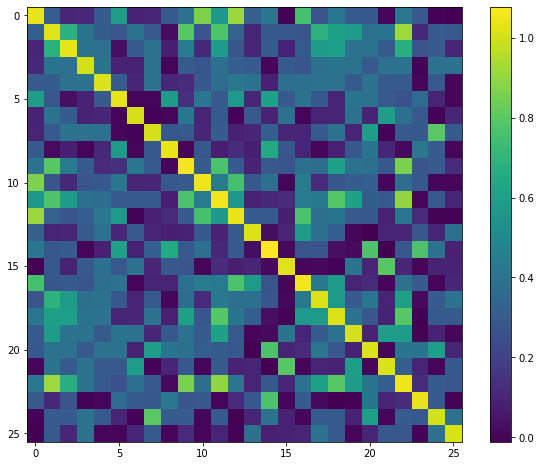

In [78]:
print("\n  Kernel Matrix during the training:\n")
kernel_matrix = result['kernel_matrix_training']
# plot this kernel matrix
plt.figure(figsize=(10, 8))
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='viridis')
plt.colorbar()
plt.show()

## Explanation of this plot  

This plot shows the **kernel matrix** of the training result of the QSVM model/ algorithm. 
First, by applying the quantum feature map, ZZFeatureMap, to remap the dataset into a higher (vector) space. 
Second, calculate the inner product of each possible pair of data points. eg. the inner product of a vector with itself is one. those points at the diagonal are exactly the amplitude of an inner product of each vector with itself,i.e, |<1|1>|^2 = 1.0 ,  |<2|2>|^2 = 1.0,  |<19|19>|^2 = 1.0 , etc. Those dark points with value of zero correspond to the inner product of two orthogonal vectors. 

# Prediction

In [83]:
result.keys()

dict_keys(['kernel_matrix_training', 'svm', 'kernel_matrix_testing', 'testing_accuracy', 'test_success_ratio'])

In [79]:
predicted_labels = qsvm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, qsvm.label_to_class)
print("Ground truth: {}".format(datapoints[1]))
print("Prediction: {}".format(predicted_labels))

# prediction accuracy
print("testing success ratio: {}".format(result['testing_accuracy']))

Ground truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Prediction: [0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1]
testing success ration: 0.5714285714285714
